# Arrhythmia
## Classification of cardiac arrhythmias through Supervised Learning

The [arrhythmia](https://archive.ics.uci.edu/dataset/5/arrhythmia) dataset consists of $452$ instances and $280$ linear features.

The first $4$ features include age, sex, height and weight from the patient. The features $5-279$ features contain ECG data on different channels, while the last feature (the **target feature**) is the arrhythmia class according to an expert cardiologist. 

In [1]:
# IMPORT LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.impute import SimpleImputer
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

### Import data
If using Google Colab, please run the following code:

In [ ]:
# from google.colab import files
# print("Please select 'arrhythmia.data'\n")
# uploaded = files.upload()

In [2]:
# Create feature list
mylist1 = ['Q wave', 'R wave', 'S wave', "R' wave", "S' wave",
            'Number of intrinsic deflections', 'Existence of ragged R wave',
            'Existence of diphasic derivation of R wave', 'Existence of ragged P wave',
            'Existence of diphasic derivation of P wave', 'Existence of ragged T wave',
            'Existence of diphasic derivation of T wave']
mylist2 = ['JJ wave', 'Q wave', 'R wave', 'S wave', "R' wave", "S' wave",
         'P wave', 'T wave', 'QRSA', 'QRSTA']
listofchannels = ['DI', 'DII', 'DIII', 'AVR', 'AVL', 'AVF', ' V1', 'V2', 'V3',
                  'V4', 'V5', 'V6']

label_list = ['Age', 'Sex', 'Height', 'Weight', 'QRS interval', 'PR interval',
              'QT interval', 'T interval', 'P interval', 'QRS', 'T', 'P', 'QRST',
              'J', 'Heart rate'] +\
             [s + ' avg width ' + t for t in listofchannels for s in mylist1] +\
             [s + ' ampl ' + t for t in listofchannels for s in mylist2] +\
             ['Class']

In [3]:
# Read dataset
df = pd.read_csv('arrhythmia.data', na_values = '?', header = None, names = label_list)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Columns: 280 entries, Age to Class
dtypes: float64(125), int64(155)
memory usage: 988.9 KB


## Preprocessing
### Missing values

In [5]:
# Measure the missing values percentage in each feature
too_many_list = []
missingvalues_list = []
for col in df.columns:
    pct_missing = np.mean(df[col].isna())
    if pct_missing != 0:
        print('{} - {} missing values - {}%'.format(col, df[col].isnull().sum(), round(pct_missing*100, ndigits=2)))
        print('dtype: {}'.format(df[col].dtypes))
        if pct_missing >= 0.6:
            too_many_list.append(col)
        else:
            missingvalues_list.append(col)

T - 8 missing values - 1.77%
dtype: float64
P - 22 missing values - 4.87%
dtype: float64
QRST - 1 missing values - 0.22%
dtype: float64
J - 376 missing values - 83.19%
dtype: float64
Heart rate - 1 missing values - 0.22%
dtype: float64


In [6]:
# Remove those with too many missing values
df = df.drop(too_many_list, axis = 1)

In [7]:
# Impute missing values with a mean strategy
df_mv = df[missingvalues_list]
df_mv_labels = df_mv.columns
df_incomplete = df.drop(missingvalues_list, axis = 1)
simp_imp = SimpleImputer(strategy = 'mean')
df_mv = simp_imp.fit_transform(df_mv)
df_mv = pd.DataFrame(df_mv, columns = df_mv_labels)
df = pd.concat([df_incomplete, df_mv], axis = 1)
print("NaN values in dataframe (after imputing): ", df.isna().sum().sum())

NaN values in dataframe (after imputing):  0


### Outliers

In [8]:
# Standard deviation of numerical features
no_var_list = []
print('Standard deviation of numerical features\n')
for col in df.columns:
    if df[col].std() == 0. or df[col].std() == 0:
        no_var_list.append(col)
        print(str(col), df[col].std())

Standard deviation of numerical features

S' wave avg width DI 0.0
S' wave avg width AVL 0.0
Existence of ragged R wave avg width AVL 0.0
Existence of ragged P wave avg width AVF 0.0
Existence of ragged P wave avg width V4 0.0
Existence of diphasic derivation of P wave avg width V4 0.0
S' wave avg width V5 0.0
Existence of ragged R wave avg width V5 0.0
Existence of ragged P wave avg width V5 0.0
Existence of ragged T wave avg width V5 0.0
S' wave avg width V6 0.0
Existence of diphasic derivation of P wave avg width V6 0.0
Existence of ragged T wave avg width V6 0.0
S' wave ampl DI 0.0
S' wave ampl AVL 0.0
S' wave ampl V5 0.0
S' wave ampl V6 0.0


In [9]:
# Remove those with zero variance
df = df.drop(no_var_list, axis = 1)

### Feature importance

In [10]:
# Compute Pearson correlation
cor_df = df.corr(method = 'pearson').round(2)
thres = 0.65
corr_matrix = cor_df.values
rows, cols = np.where(np.abs(corr_matrix) > thres)
index = np.where(rows != cols)
rows_to_drop = rows[index][:round(len(rows[index]) / 2)]
cols_to_drop = cols[index][:round(len(rows[index]) / 2)]

print('Columns with |correlation| > ' + str(thres) + ':\n', rows_to_drop)

Columns with |correlation| > 0.65:
 [  2   2   2   5   8   9   9   9   9   9   9   9  10  11  12  13  15  21
  22  22  23  23  24  25  29  31  32  33  34  34  35  35  37  44  45  45
  45  46  46  47  47  47  48  49  50  53  53  55  56  57  58  58  59  60
  64  66  66  66  66  66  66  67  68  68  68  69  69  69  69  71  75  78
  78  79  79  80  80  80  81  82  90  90  91  91  92  93  94  94 102 102
 103 103 103 103 104 105 106 106 106 106 107 114 114 116 117 118 122 124
 124 124 125 127 128 132 132 133 133 135 136 137 139 141 141 141 141 142
 143 143 143 144 144 145 147 147 147 147 147 148 148 148 148 149 149 150
 150 150 151 151 152 152 152 152 152 152 152 152 153 153 153 153 153 154
 154 154 154 154 155 156 156 156 157 157 157 157 158 158 158 158 158 158
 158 158 158 159 159 159 159 159 159 159 159 160 160 161 162 162 162 162
 162 162 163 163 164 164 164 165 166 166 166 167 167 168 168 168 168 168
 168 168 168 168 168 168 168 168 168 169 169 169 169 169 169 169 169 169
 169 170 170 17

In [11]:
# Drop features with correlation higher than 65%
df = df.drop(columns = df.columns[rows_to_drop])

### Scaling

In [12]:
# Separate 'Class' feature from scaling, as it is a categorical feature instead of a numerical one
class_feature = df['Class']
df = df.drop(columns = 'Class')

scaler = MinMaxScaler(feature_range = (0,1))
scaled_df = scaler.fit_transform(df)
df = pd.DataFrame(scaled_df, columns = df.columns)
df = pd.concat([df, class_feature], axis = 1)

### Save preprocessed dataset, if needed

In [13]:
# Save dataframe as pickle file
df.to_pickle("./arrhytmia.pkl")

## Data visualization and dataset preparation

Number of instances per class:
 1     245
10     50
2      44
6      25
16     22
3      15
4      15
5      13
9       9
15      5
14      4
7       3
8       2
11      0
12      0
13      0
dtype: int64


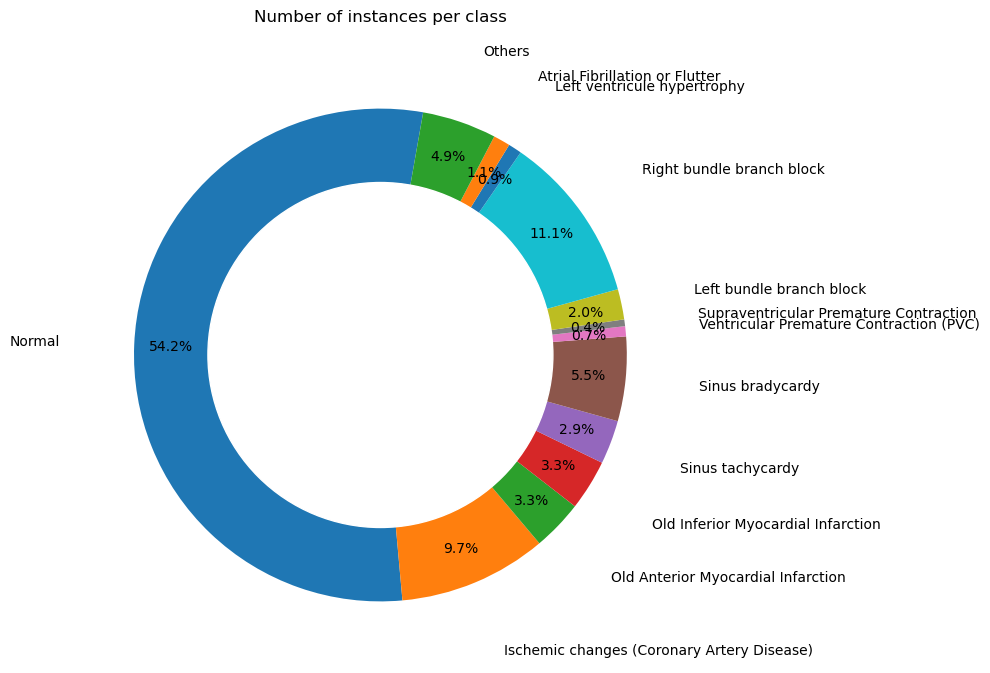

In [14]:
# Count instances of the 16 classes
per_class = df['Class'].value_counts()
adj = pd.Series(data = [0, 0, 0], index = ['11', '12', '13'], name = 'Class')
per_class2 = pd.concat([per_class, adj])
print('Number of instances per class:\n', per_class2)

per_class = per_class.sort_index()
plt.figure(figsize = (8,8))
my_circle = plt.Circle((0,0), 0.7, color = 'white')
label_diseases = ['Normal', 'Ischemic changes (Coronary Artery Disease)',
                    'Old Anterior Myocardial Infarction', 'Old Inferior Myocardial Infarction',
                    'Sinus tachycardy', 'Sinus bradycardy', 'Ventricular Premature Contraction (PVC)',
                    'Supraventricular Premature Contraction', 'Left bundle branch block',
                    'Right bundle branch block', 'Left ventricule hypertrophy',
                    'Atrial Fibrillation or Flutter', 'Others']
plt.pie(per_class, labels = label_diseases, autopct = '%1.1f%%', pctdistance = 0.85, labeldistance = 1.3, startangle = 80)
plt.title("Number of instances per class\n")
fig=plt.gcf()
fig.gca().add_artist(my_circle)
plt.show()

### Split dataset in $90-10\%$

In [31]:
# Train-test split
df_train, df_test = train_test_split(df, test_size = 0.2)
target_train = df_train['Class']
target_train = pd.Series.astype(target_train, dtype = np.int32)
target_test = df_test['Class']
target_test = pd.Series.astype(target_test, dtype = np.int32)
df_train = df_train.drop(labels = 'Class', axis = 1)
df_test = df_test.drop(labels = 'Class', axis = 1)

### Functions

In [32]:
# Compute classification metrics
def metrics(true, pred, classifier):
    accuracy = accuracy_score(true, pred)
    precision = precision_score(true, pred, average = 'macro')
    recall = recall_score(true, pred, average = 'macro')
    f1 = f1_score(true, pred, average = 'macro')
    data_metrics = pd.DataFrame(np.array([[accuracy], [precision], [recall], [f1]]).T,
                                columns = ['accuracy', 'precision', 'recall', 'f1'])
    data_class = pd.DataFrame([classifier], columns = ['classifier'])
    dataframe = pd.concat([data_class, data_metrics], axis = 1)
    return dataframe

# Plot confusion matrix
def plots(target_test, pred, title):
    conf_display = ConfusionMatrixDisplay.from_predictions(target_test, pred)
    plt.close('all')
    plt.figure()
    plt.title('Confusion matrix of ', title)
    plt.plot(conf_display)
    plt.show()

# Create metrics_df
metrics_df = pd.DataFrame(columns = ['classifier', 'accuracy', 'precision', 'recall', 'f1'])

# Update metrics_df
def conc(metrics_df, metr, title):
    if (title in metrics_df['classifier'].unique()) == False:
        metrics_df = pd.concat([metrics_df, metr], ignore_index = True)
    else:
        ind = metrics_df.index[metrics_df['classifier'] == title].tolist()
        metr_data = pd.DataFrame(metr, columns=['classifier', 'accuracy', 'precision', 'recall', 'f1'], index = ind)
        metrics_df.update(metr_data)
    return metrics_df

## Classification
### k-Nearest Neighbors
Let $Y=\{1,...,n\}$ be the set of possible classes and $x$ be the generic point one wants to know the belonging class of. The k-NN method assigns to $x$ the most frequent class over the ones the $k$ closer points to $x$ have assigned.

### Algorithm
*   Choose the number $k$ of neighbors;
*   Compute the Euclidean distance from $x$ to the points $x_i\quad i=1,...,n$. The distance order generates a permutation $\sigma$ of indexes such that
\begin{equation*}
	\| x-x_{\sigma(1)}\| \le \| x-x_{\sigma(2)}\|\le \dots \| x-x_{\sigma(n)}\|;
\end{equation*}
*   Count how many point belong to each class;
*   Assign to $x$ the class to which belongs the majority of neighbors.

In [ ]:
parameters = {'n_neighbors': range(3, 11, 2)}
neigh = KNeighborsClassifier()
clf = GridSearchCV(estimator = neigh, param_grid = parameters, n_jobs = 8)
clf.fit(df_train, target_train)
print('Best parameters:', clf.best_params_, '\n Score:', clf.best_score_)

k = clf.best_params_['n_neighbors']
neigh3 = KNeighborsClassifier(n_neighbors = k)
title = str(k) + ' Nearest Neighbors'
neigh3.fit(df_train, target_train)
pred = neigh3.predict(df_test)
prob_pred = neigh3.predict_proba(df_test)
print('\nNumber of neighbors:', k, '\n\n Classification report:\n', 
        classification_report(target_test, pred, output_dict = False))

plots(target_test, pred, title)
metr = metrics(target_test, pred, title)
metrics_df = conc(metrics_df, metr, title)

### Support Vector Classifier
The Support Vector Machine (SVM) algorithm ims to find the hyperplane in a $p$-dimensional space (where $p$ is the number of features) that allows to classify the points of the hyperspace in a distinct way. SVM determines the optimal hyperplane, that maximizes the distance between point belonging to distinct classes. 

Applying a transformation on data, the problem can be re-formulated in a feature space of higher dimension, in order to linearly separate the data.

To do so without computing the coordinated of data in the higher-dimensional space, one can use the **Kernel trick**. A function $k:X \times X \to \mathbb{R}$ is called a **kernel** if there exist a Hilbert space $H$ and a map $\phi: X \mapsto H$ such that

\begin{equation*}
	k(\mathbf{x},\mathbf{x'}):= \langle \phi(\mathbf{x}),\phi(\mathbf{x'}) \rangle_H \quad \forall \mathbf{x}, \mathbf{x'} \in H
\end{equation*}

where $\phi$ is called **feature map** and $H$ **feature space**.

The most common kernels are:

*	Linear Kernel
\begin{equation*}
	k(\mathbf{x},\mathbf{x'})=\langle \mathbf{x},\mathbf{x'} \rangle
\end{equation*}

*	Polynomial Kernel
\begin{equation*}
    k(\mathbf{x},\mathbf{x'})=(\gamma\langle \mathbf{x},\mathbf{x'} \rangle)^d
\end{equation*}

*	Radial Basis Function (RBF) Kernel
\begin{equation*}
	k(\mathbf{x},\mathbf{x'})=e^{-\gamma\|\mathbf{x}-\mathbf{x'}\|^2}
\end{equation*}

*	Sigmoid Kernel
\begin{equation*}
	k(\mathbf{x},\mathbf{x'})=\tanh(\gamma\langle \mathbf{x},\mathbf{x'} \rangle)
\end{equation*}

In [ ]:
parameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
              'degree': list(range(2,6)), 
              'gamma': ['scale', 'auto']}
svc = SVC()
clf = RandomizedSearchCV(estimator = svc, 
                         param_distributions = parameters, 
                         n_jobs = 8)
clf.fit(df_train, target_train)
print('Best parameters for Random Forest:', clf.best_params_, '\n Score:', clf.best_score_)

ker = clf.best_params_['kernel']
deg = clf.best_params_['degree']
gam = clf.best_params_['gamma']
svc = SVC(kernel = ker, degree = deg, 
          gamma = gam, probability = True)
title = 'SVC (ker=' + str(ker) + '; degree=' + str(deg) + '; gamma=' + str(gam) + ')'
svc.fit(df_train, target_train)
pred = svc.predict(df_test)
print('Classification report:\n', 
      classification_report(target_test, pred, output_dict = False))

plots(target_test, pred, title)
metr = metrics(target_test, pred, title)
metrics_df = conc(metrics_df, metr, title)

### Gaussian Naive Bayes

This is a probabilistic algorithm used for classification tasks, based on computing the probability that $x$ belongs to a given class. 

It is based on the Conditional Probability Theorem (also known as **Bayes Theorem**)
\begin{equation*}
    \mathbb{P}(y|x_1,x_2, \dots,x_n)=\frac{\mathbb{P}(x_1,x_2,\dots,x_n|y) \cdot \mathbb{P}(y)}{\mathbb{P}(x_1,x_2,\dots,x_n)}
\end{equation*}

Under the **Naive hypothesis** that the features are mutually independent,
\begin{equation*}
	\mathbb{P}(x_1,x_2,\dots,x_n|y)=\mathbb{P}(x_1,|y) \cdot \mathbb{P}(x_2|y) \cdots \mathbb{P}(x_n|y)
\end{equation*}

Moreover, being $\mathbb{P}(x_1,...,x_n)$ a constant, it is possible to assume that
\begin{equation*}
	\mathbb{P}(y | x_1,...,x_n) \propto \mathbb{P}(y) \prod_{i=1}^n \mathbb{P}(x_i|y)
\end{equation*}

Therefore the assigned class is
\begin{equation*}
	\hat{y}=\arg \max_y \mathbb{P}(y)\prod_{i=1}^n \mathbb{P}(x_i|y) .
\end{equation*}

The most common Bayesian classifier uses a conditional probability of the **gaussian** type, i.e.
\begin{equation*}
	\mathbb{P}(x_i|y)=\frac{1}{\sqrt{2 \pi \sigma_{y}^2}} \exp\Biggl\{ -\frac{(x_i - \mu_{y})^2}{2 \sigma_{y}^2}\Biggr\}
\end{equation*}
where $\sigma_y$ e $\mu_y$ are determined through the Maximum Likelihood Estimation method.

In [ ]:
gnb = GaussianNB()
title = 'Gaussian Naive Bayes'
gnb.fit(df_train, target_train)
pred = gnb.predict(df_test)
print('Classification report:\n', 
      classification_report(target_test, pred, output_dict = False))

plots(target_test, pred, title)
metr = metrics(target_test, pred, title)
metrics_df = conc(metrics_df, metr, title)

### Ridge Classifier
It is based on Ridge regression, a regularized version of linear regression obtained by adding a **penalty factor** in the function to minimize, i.e.
\begin{equation*}
	\min_\mathbf{w} \|\mathbf{x}\mathbf{w}-y\|_2^2+\alpha\|(w_1,...,w_p)\|_2^2.
\end{equation*}
where $\mathbf{x}=(x_1,...,x_p)$ are the feature values and $\mathbf{w}=(w_0,w_1,...,w_p)$ is the parameter vector, including the bias term $w_0$.

More specifically:
* If $\alpha=0$, Ridge regression coincides with linear regression;
* If $\alpha>>0$, all the coefficients become close to zero and the result is a plane line through the data mean. 

In [ ]:
parameters = {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 
                        0.6, 0.7, 0.8, 0.9, 1.0]}
clf = RidgeClassifier()
clf = GridSearchCV(estimator = clf, param_grid = parameters, n_jobs = 8)
clf.fit(df_train, target_train)
print('Best parameters for Ridge Classifier:', clf.best_params_,
      '\n Score:', clf.best_score_)

k = clf.best_params_['alpha']
RidgeClassifier = RidgeClassifier(alpha = k)
title = 'Ridge Classifier (alpha=' + str(k) + ')'
RidgeClassifier.fit(df_train, target_train)
pred = RidgeClassifier.predict(df_test)
print('Alpha:', k, '\n\n Classification report:\n', 
      classification_report(target_test, pred, output_dict = False))

plots(target_test, pred, title)
metr=metrics(target_test, pred, title)
metrics_df=conc(metrics_df, metr, title)

### Logistic Regression

It is used to estimate the probability that an istance belongs to a given class. In binary classification, if this probability is higher than $0.5$, the model predicts that $x$ belongs to class $1$, otherwise to class $0$. 

**Algorithm**
1. Compute a weighted mean of some features, including the bias term
\begin{equation*}
    t=w_0+w_1x_1+...+w_px_p;
\end{equation*}

2. Compute the *logistic function* $\sigma:t\in\mathbb{R}\to\frac{1}{1+e^{-t}}\in(0,1)$ of $t$, in order to obtain
\begin{equation*}
	\hat{p}(t)=\sigma(t)=\frac{1}{1+e^{-(w_0+w_1x_1+...+w_px_p)}};
\end{equation*}

3. Based on the predicted probability $\hat{p}(t)$, assign a class.

In [ ]:
parameters = {'C': [100, 10, 1.0, 0.1, 0.01]}
clf = LogisticRegression(max_iter = 1000)
clf = GridSearchCV(estimator = clf, param_grid = parameters, n_jobs = 8)
clf.fit(df_train, target_train)
print('Best parameters for Logistic Regression Classifier:', clf.best_params_,
      '\n Score:', clf.best_score_)

k = clf.best_params_['C']
logreg = LogisticRegression(C = k, max_iter = 1000)
title = 'Logistic Regression (C=' + str(k) + ')'
logreg.fit(df_train, target_train)
pred = logreg.predict(df_test)
print('C:', k, '\n\nClassification report:\n', 
      classification_report(target_test, pred, output_dict = False))

plots(target_test, pred, title)
metr = metrics(target_test, pred, title)
metrics_df = conc(metrics_df, metr, title)

### Metrics results

In [ ]:
metrics_df

,classifier,accuracy,precision,recall,f1
0,3 Nearest Neighbors,0.478261,0.478261,0.478261,0.478261
1,SVC (ker=linear; degree=4; gamma=auto),0.652174,0.652174,0.652174,0.652174
2,Gaussian Naive Bayes,0.195652,0.195652,0.195652,0.195652
3,Ridge Classifier (alpha=0.8),0.652174,0.562857,0.492857,0.503860
4,Logistic Regression (C=10),0.760870,0.760870,0.760870,0.760870
